In [1]:
import re
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action="ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn import svm
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix, classification_report
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB

In [2]:
# Load the df dataframe
df_ml = pd.read_csv('yelp_ml.csv')

In [3]:
df_ml.head()

,is_open,business_id,name,stars,review_count,categories,attributes.RestaurantsTableService,attributes.WiFi,attributes.BikeParking,attributes.BusinessAcceptsCreditCards,...,attributes.divey,attributes.trendy,attributes.classy,attributes.casual,attributes.dessert,attributes.latenight,attributes.lunch,attributes.dinner,attributes.brunch,attributes.breakfast
0,1,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86,"Gastropubs, Food, Beer Gardens, Restaurants, B...",True,'free',True,True,...,False,False,False,True,False,False,False,False,False,False
1,1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,4.0,126,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Not listed,'free',False,True,...,False,False,False,True,False,False,True,False,False,True
2,1,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3.5,169,"Restaurants, Thai",Not listed,'no',True,Not listed,...,False,False,False,True,False,False,True,True,False,False
3,1,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,4.5,11,"Breakfast & Brunch, Restaurants",Not listed,Not listed,Not listed,Not listed,...,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed
4,1,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,4.0,39,"Food, Pizza, Restaurants",False,'free',True,True,...,False,False,False,True,Not listed,Not listed,Not listed,Not listed,Not listed,Not listed


# Categories - Natural Language Processing (NLP)

In [4]:
# Create a dataframe with only categories
df_nlp = df_ml[['categories']]
df_nlp.head()

,categories
0,"Gastropubs, Food, Beer Gardens, Restaurants, B..."
1,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
2,"Restaurants, Thai"
3,"Breakfast & Brunch, Restaurants"
4,"Food, Pizza, Restaurants"


In [5]:
# Define a method to remove punctuations
def remove_punc(text):
    result = ''.join([word for word in text if word not in string.punctuation])
    return result

In [6]:
# Assign puncutation removed words
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: remove_punc(x))
df_nlp.head()

,categories
0,Gastropubs Food Beer Gardens Restaurants Bars ...
1,Salad Soup Sandwiches Delis Restaurants Cafes ...
2,Restaurants Thai
3,Breakfast Brunch Restaurants
4,Food Pizza Restaurants


In [7]:
# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [8]:
# Tokenize the words and assign
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: tokenizer.tokenize(x.lower()))
df_nlp.head()

,categories
0,"[gastropubs, food, beer, gardens, restaurants,..."
1,"[salad, soup, sandwiches, delis, restaurants, ..."
2,"[restaurants, thai]"
3,"[breakfast, brunch, restaurants]"
4,"[food, pizza, restaurants]"


In [9]:
# Define a function to remove stopwords
def remove_stopwords(text):
    result = [word for word in text if word not in stopwords.words('english')]
    return result

In [10]:
# Remove stopwords
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: remove_stopwords(x))
df_nlp.head()

,categories
0,"[gastropubs, food, beer, gardens, restaurants,..."
1,"[salad, soup, sandwiches, delis, restaurants, ..."
2,"[restaurants, thai]"
3,"[breakfast, brunch, restaurants]"
4,"[food, pizza, restaurants]"


In [11]:
# Stemmer
stemmer = PorterStemmer()

In [12]:
# Define a function for stemming the words
def stem_text(text):
    result = [stemmer.stem(word) for word in text]
    return result

In [13]:
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: stem_text(x))
df_nlp.head()

,categories
0,"[gastropub, food, beer, garden, restaur, bar, ..."
1,"[salad, soup, sandwich, deli, restaur, cafe, v..."
2,"[restaur, thai]"
3,"[breakfast, brunch, restaur]"
4,"[food, pizza, restaur]"


In [14]:
# Lemmatize
lemmatizer = WordNetLemmatizer()

In [15]:
# Define a function to lemmatize
def lemmatize(text):
    result = [lemmatizer.lemmatize(word) for word in text]
    return result

In [16]:
# Lemmatize the words
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: lemmatize(x))
df_nlp.head()

,categories
0,"[gastropub, food, beer, garden, restaur, bar, ..."
1,"[salad, soup, sandwich, deli, restaur, cafe, v..."
2,"[restaur, thai]"
3,"[breakfast, brunch, restaur]"
4,"[food, pizza, restaur]"


In [17]:
# Remove the list by joining
df_nlp['categories'] = df_nlp['categories'].apply(lambda x: ' '.join(x))

In [18]:
df_nlp.head()

,categories
0,gastropub food beer garden restaur bar america...
1,salad soup sandwich deli restaur cafe vegetarian
2,restaur thai
3,breakfast brunch restaur
4,food pizza restaur


##### CountVectorizer was used instead of TfidfVectorizer since the frequency of the word is not of interest. For example, 'food' is almost always assisted by another word or words. "Ethnic food" or "Food truck" would be 'Ethnic' and 'truck".

In [19]:
# Use CountVectorizer on categories
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_nlp['categories'])
X_count_feat = X_counts.toarray()
X_count_feat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
# Copy the values of 'is_open' from original dataframe to NLP dataframe
df_nlp['is_open'] = df_ml['is_open'].copy()

In [21]:
# Create 'body_len' column which counts the total number of words in each row
df_nlp['body_len'] = df_nlp['categories'].apply(lambda x: len(x) - x.count(' '))

In [22]:
df_nlp.head()

,categories,is_open,body_len
0,gastropub food beer garden restaur bar america...,1,69
1,salad soup sandwich deli restaur cafe vegetarian,1,42
2,restaur thai,1,11
3,breakfast brunch restaur,1,22
4,food pizza restaur,1,16


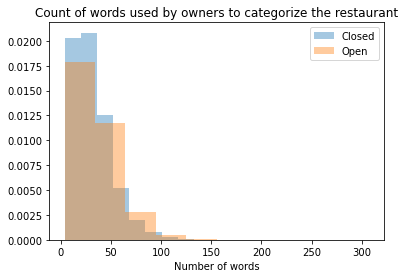

In [23]:
# Plot open vs. closed word counts used by owners to categorize their restaurant
plt.hist(df_nlp[df_nlp['is_open'] == 0]['body_len'], alpha=0.4, density=True, label='Closed', bins=10)
plt.hist(df_nlp[df_nlp['is_open'] == 1]['body_len'], alpha=0.4, density=True, label='Open', bins=10)
plt.title('Count of words used by owners to categorize the restaurant')
plt.xlabel('Number of words')
plt.legend(loc='upper right')
plt.show()

# Train Test Split

In [24]:
# How big is X_count_feat?
X_count_feat.shape

(61328, 815)

In [25]:
# If sum of the column is less than 85% of column size, then drop
dummy = pd.DataFrame(X_count_feat)
dummy = dummy[dummy.columns[dummy.sum() >= (X_count_feat.shape[1] * 0.85)]]
dummy['is_open'] = df_ml['is_open'].copy()

In [26]:
# Assign X and Y
X = dummy.drop('is_open', axis=1)
y = dummy['is_open']

# Split the data into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y)

# Bernoulli Naive Bayes - Categories

### Baseline Model - Bernoulli Naive Bayes

There isn't a class weight in the parameter, so we will have to use upsampled train test samples

In [27]:
# Concatenate the training data
df_Xy_train = pd.concat([y_train, X_train], axis=1)
df_Xy_train.head()

,is_open,17,32,34,46,50,51,61,83,85,...,725,743,753,768,769,774,779,804,806,812
4537,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55562,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
43077,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8597,1,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Separate closed and open restaurants
df_closed = df_Xy_train[df_Xy_train.is_open == 0]
df_open = df_Xy_train[df_Xy_train.is_open == 1]

In [29]:
print('From the training set, there are {} closed restaurants.'.format(len(df_closed)))
print('From the training set, there are {} open restaurants.'.format(len(df_open)))

From the training set, there are 14999 closed restaurants.
From the training set, there are 27930 open restaurants.


In [30]:
# Upsample closed restaurants
df_closed = resample(df_closed, replace=True, n_samples=len(df_open), random_state=3) 

In [31]:
# Combine open and upsampled closed restaurants
df_upsampled = pd.concat([df_closed, df_open])

In [32]:
# Split the upsampled data into X_train and y_train
X_train_up = df_upsampled.drop('is_open', axis=1)
y_train_up = df_upsampled['is_open']

In [33]:
# Fit the data and predict
model = BernoulliNB()
model.fit(X_train_up, y_train_up)
y_pred = model.predict(X_test)

In [34]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.67      0.52      6429
           1       0.74      0.51      0.60     11970

    accuracy                           0.56     18399
   macro avg       0.58      0.59      0.56     18399
weighted avg       0.63      0.56      0.57     18399



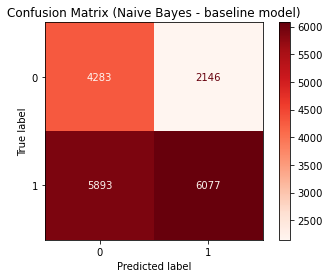

In [35]:
# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Naive Bayes - baseline model)')
plt.show()

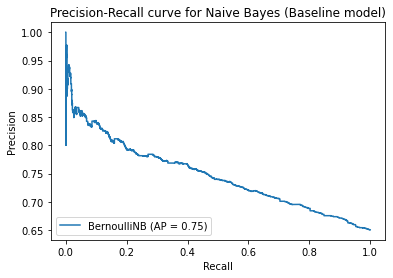

In [36]:
# Plot Precision Recall Curve
plot_precision_recall_curve(model, X_test, y_test)
plt.title('Precision-Recall curve for Naive Bayes (Baseline model)')
plt.show()

### Search for the best hyper parameter using RandomSearchCV - Bernoulli Naive Bayes

In [37]:
# Define KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

In [38]:
# Set the parameters to search for
model2 = BernoulliNB()

nb_grid = {'alpha': np.linspace(0, 2, 20),
           'fit_prior':[True, False],
           'binarize': np.linspace(0, 1, 10),
          }

In [39]:
# Define Random Search CV
model_random = RandomizedSearchCV(estimator = model2, param_distributions=nb_grid, cv = kfold, random_state=3, n_jobs = -1)

In [40]:
# Fit the random search model (using upsampled)
model_random.fit(X_train_up, y_train_up)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
                   estimator=BernoulliNB(), n_jobs=-1,
                   param_distributions={'alpha': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ]),
                                        'binarize': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'fit_prior': [True, False]},
                   random_state=3)

In [41]:
model_random.best_params_

{'fit_prior': True,
 'binarize': 0.1111111111111111,
 'alpha': 0.42105263157894735}

In [42]:
# Fit the data with best params and predict
model2 = BernoulliNB(**model_random.best_params_)
model2.fit(X_train_up, y_train_up)
y_pred2 = model2.predict(X_test)

In [43]:
# Print classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.42      0.67      0.52      6429
           1       0.74      0.51      0.60     11970

    accuracy                           0.56     18399
   macro avg       0.58      0.59      0.56     18399
weighted avg       0.63      0.56      0.57     18399



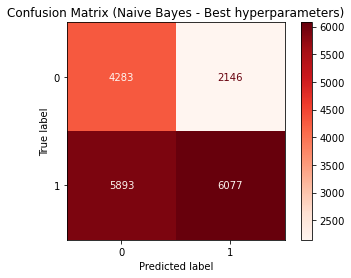

In [44]:
# Plot confusion matrix
plot_confusion_matrix(model2, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Naive Bayes - Best hyperparameters)')
plt.show()

In [45]:
# Print average cross val score
print('Average cross validation score: %.3f' % cross_val_score(model2, X_train_up, y_train_up, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.558


# Categories - Logistic Regression

### Baseline Model - Logistic Regression

In [46]:
# Logistic Regression - Baseline model
lr = LogisticRegression(max_iter=1000, random_state=3)

In [47]:
# Fit the data and predict
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [48]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.16      0.24      6429
           1       0.67      0.94      0.78     11970

    accuracy                           0.66     18399
   macro avg       0.62      0.55      0.51     18399
weighted avg       0.64      0.66      0.60     18399



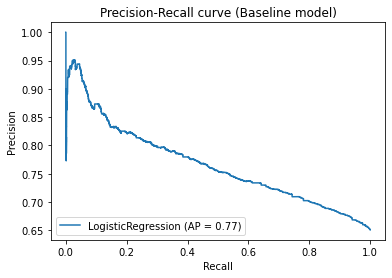

In [49]:
# Plot precision recall curve
plot_precision_recall_curve(lr, X_test, y_test)
plt.title('Precision-Recall curve (Baseline model)')
plt.show()

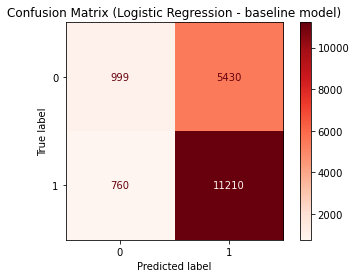

In [50]:
# Plot confusion matrix
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Logistic Regression - baseline model)')
plt.show()

#### Let's not forget! We have imbalanced dataset.

In [51]:
print('There are {} closed restaurants.'.format(len(df_ml[df_ml.is_open == 0])))
print('There are {} open restaurants.'.format(len(df_ml[df_ml.is_open == 1])))

There are 21428 closed restaurants.
There are 39900 open restaurants.


##### Balancing techniques will have to be used to balanced the dataset.

### Class Weight vs. Upsampling performance - Logistic Regression

Theoretically, applying class weight vs. upsampling should be almost exactly the same. But both performances will be tested on a baseline model to see which performs better.

#### Class weight performance

In [52]:
# Define class weight
weight = {0: (len(df_ml[df_ml.is_open == 1])/len(df_ml[df_ml.is_open == 0])) , 1:1}

# Fit the data and predict
lr2 = LogisticRegression(max_iter=1000, random_state=3, class_weight=weight)
lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)

In [53]:
# Print classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.43      0.69      0.53      6429
           1       0.75      0.51      0.61     11970

    accuracy                           0.57     18399
   macro avg       0.59      0.60      0.57     18399
weighted avg       0.64      0.57      0.58     18399



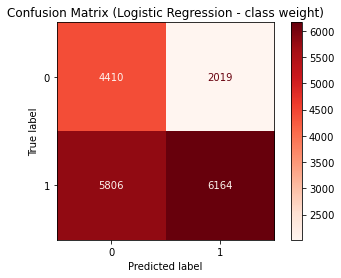

In [54]:
plot_confusion_matrix(lr2, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Logistic Regression - class weight)')
plt.show()

In [55]:
# Average cross validation score
print('Average cross validation score: %.3f' % cross_val_score(lr2, X_train, y_train, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.617


#### Upsampling performance

In [56]:
# Fit the data and predict
lr3 = LogisticRegression(max_iter=1000, random_state=3)
lr3.fit(X_train_up, y_train_up)
y_pred3 = lr3.predict(X_test)

In [57]:
# Print classification report
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.43      0.68      0.53      6429
           1       0.75      0.51      0.61     11970

    accuracy                           0.57     18399
   macro avg       0.59      0.60      0.57     18399
weighted avg       0.64      0.57      0.58     18399



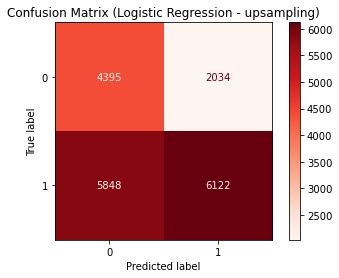

In [58]:
plot_confusion_matrix(lr3, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Logistic Regression - upsampling)')
plt.show()

In [59]:
# Print average cross val score
print('Average cross validation score: %.3f' % cross_val_score(lr3, X_train_up, y_train_up, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.569


##### Class weight and Upsampling resulted in same weighted avg f1 scores, but 'class weight' had better average f1 cross validation score

### Search for the best hyper parameter using RandomSearchCV - Logistic Regression.

In [60]:
# Set the parameters to search for
lr5 = LogisticRegression(class_weight=weight, random_state=3)

lr_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
           'dual':[True, False],
          'max_iter':[int(x) for x in np.linspace(start=1000, stop=3000, num=100)],
          'C':[0.25, 0.5, 1.0, 1.5]}

In [61]:
# Define Random Search CV
lr_random = RandomizedSearchCV(estimator = lr5, param_distributions=lr_grid, cv = kfold, random_state=3, n_jobs = -1)

In [62]:
# Fit the training data
lr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
                   estimator=LogisticRegression(class_weight={0: 1.8620496546574576,
                                                              1: 1},
                                                random_state=3),
                   n_jobs=-1,
                   param_distributions={'C': [0.25, 0.5, 1.0, 1.5],
                                        'dual': [True, False],
                                        'max_iter': [1000, 1020, 1040, 1060,
                                                     1080, 1101, 1121, 1141,
                                                     1161, 1181, 1202, 1222,
                                                     1242, 1262, 1282, 1303,
                                                     1323, 1343, 1363, 1383,
                                                     1404, 1424, 1444, 1464,
                                                     1484, 1505, 1525, 1545,
          

In [63]:
# Print the best parameters
print(lr_random.best_params_)

{'penalty': 'l2', 'max_iter': 2959, 'dual': False, 'C': 0.25}


In [64]:
# Instantiate LogisticRegression
lr6 = LogisticRegression(**lr_random.best_params_, class_weight=weight, random_state=3)

In [65]:
# Fit data and predict
lr6.fit(X_train, y_train)
y_pred6 = lr6.predict(X_test)

In [66]:
# Print classification report
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.43      0.68      0.53      6429
           1       0.75      0.52      0.61     11970

    accuracy                           0.58     18399
   macro avg       0.59      0.60      0.57     18399
weighted avg       0.64      0.58      0.58     18399



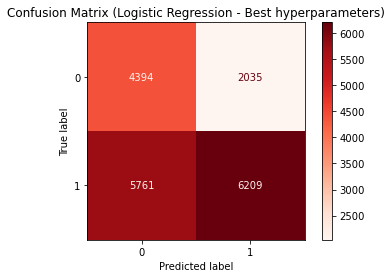

In [67]:
# Plot confusion matrix
plot_confusion_matrix(lr6, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Logistic Regression - Best hyperparameters)')
plt.show()

In [68]:
# Check cross validated classification report
cross_predicted = cross_val_predict(lr6, X, y, cv=kfold)
print(classification_report(y, cross_predicted))

              precision    recall  f1-score   support

           0       0.43      0.69      0.53     21428
           1       0.76      0.51      0.61     39900

    accuracy                           0.58     61328
   macro avg       0.60      0.60      0.57     61328
weighted avg       0.64      0.58      0.58     61328



In [69]:
print('Average cross validation score: %.3f' % cross_val_score(lr6, X_train, y_train, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.618


#### RandomSearchCV did not improve weighted avg f1 scores for logistic regression. 
### Best weighted average f1 score was 0.58, while best cross validation score with 5-kfold was 0.62

# Categories - Random Forest

### Random Forest Baseline Model - Categories

In [70]:
# Random Forest Baseline Model
rf = RandomForestClassifier(n_estimators=100, random_state=3)

In [71]:
# Fit data, predict, and print accuracy
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [72]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.29      0.37      6429
           1       0.69      0.84      0.75     11970

    accuracy                           0.65     18399
   macro avg       0.59      0.56      0.56     18399
weighted avg       0.62      0.65      0.62     18399



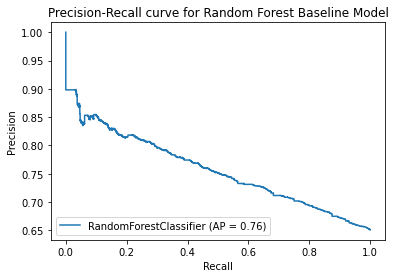

In [73]:
# Plot Precision Recall Curve
plot_precision_recall_curve(rf, X_test, y_test)
plt.title('Precision-Recall curve for Random Forest Baseline Model')
plt.show()

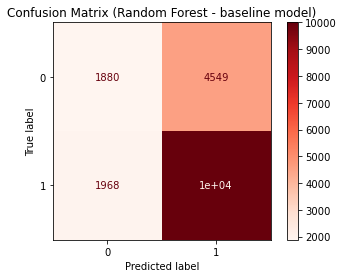

In [74]:
# Plot confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Random Forest - baseline model)')
plt.show()

### Class Weight vs. Upsampling performance - Random Forest

##### Class weight performance

In [75]:
# Fit the data and predict
rf2 = RandomForestClassifier(n_estimators=100, random_state=3, class_weight=weight)
rf2.fit(X_train, y_train)
y_pred2 = rf2.predict(X_test)

In [76]:
# Print classification report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.44      0.61      0.51      6429
           1       0.74      0.58      0.65     11970

    accuracy                           0.59     18399
   macro avg       0.59      0.60      0.58     18399
weighted avg       0.63      0.59      0.60     18399



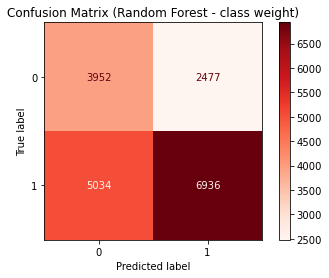

In [77]:
# Plot confusion matrix
plot_confusion_matrix(rf2, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Random Forest - class weight)')
plt.show()

In [78]:
# Average cross validation score
print('Average cross validation score: %.3f' % cross_val_score(rf2, X_train, y_train, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.660


##### Upsampling performance

In [79]:
# Fit the data and predict
rf3 = RandomForestClassifier(n_estimators=100, random_state=3)
rf3.fit(X_train_up, y_train_up)
y_pred3 = rf3.predict(X_test)

In [80]:
# Print classification report
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.44      0.62      0.51      6429
           1       0.73      0.57      0.64     11970

    accuracy                           0.59     18399
   macro avg       0.59      0.59      0.58     18399
weighted avg       0.63      0.59      0.60     18399



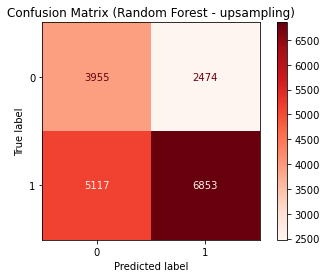

In [81]:
plot_confusion_matrix(rf3, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Random Forest - upsampling)')
plt.show()

In [82]:
# Print average cross val score
print('Average cross validation score: %.3f' % cross_val_score(rf3, X_train_up, y_train_up, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.643


##### Class weight and Upsampling resulted in same weighted avg f1 scores, but 'class weight had better average f1 cross validation score

### Search for the best hyper parameter using RandomSearchCV - Random Forest

In [83]:
# Create the base model to tune
rf5 = RandomForestClassifier(class_weight=weight, random_state=3)

random_grid = {'bootstrap': [True, False],
                'max_depth': [50, 70, 90, 120, None],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 4, 8],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [25, 50, 100, 125]
              }

In [84]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = rf5, 
                               param_distributions = random_grid, 
                               cv = kfold, 
                               verbose=2, 
                               random_state=3, 
                               n_jobs = -1
                              )

In [85]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
                   estimator=RandomForestClassifier(class_weight={0: 1.8620496546574576,
                                                                  1: 1},
                                                    random_state=3),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 70, 90, 120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [25, 50, 100, 125]},
                   random_state=3, verbose=2)

In [86]:
print(rf_random.best_params_)

{'n_estimators': 125, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


In [87]:
# Fit the data and predict
rf6 = RandomForestClassifier(**rf_random.best_params_, class_weight=weight, random_state=3)
rf6.fit(X_train, y_train)
y_pred6 = rf6.predict(X_test)

In [88]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.45      0.67      0.54      6429
           1       0.76      0.55      0.64     11970

    accuracy                           0.60     18399
   macro avg       0.60      0.61      0.59     18399
weighted avg       0.65      0.60      0.60     18399



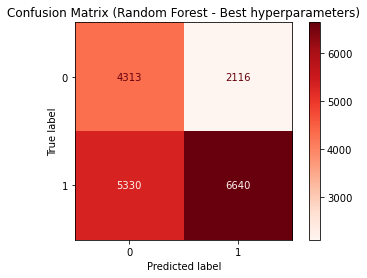

In [89]:
# Plot confusion matrix
plot_confusion_matrix(rf6, X_test, y_test, cmap=plt.cm.Reds)
plt.title('Confusion Matrix (Random Forest - Best hyperparameters)')
plt.show()

In [90]:
# Print average cross val score
print('Average cross validation score: %.3f' % cross_val_score(rf6, X_train_up, y_train_up, cv=kfold, scoring='f1').mean())

Average cross validation score: 0.421


#### RandomSearchCV did not improve weighted avg f1 scores for Random Forest. 
### Best weighted average f1 score was 0.60, while best cross validation score with 5-kfold was 0.64

# Categories - Keras

In [91]:
# Keras doesn't have f1, so define functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [92]:
# Define then run the Keras model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m, precision_m, recall_m])

# fit the model
hist = model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_split=0.3, class_weight=weight)

Epoch 1/10
940/940 [==============================] - 8s 7ms/step - loss: 0.9999 - acc: 0.5218 - f1_m: 0.4809 - precision_m: 0.7058 - recall_m: 0.4046 - val_loss: 0.7456 - val_acc: 0.4202 - val_f1_m: 0.2307 - val_precision_m: 0.8146 - val_recall_m: 0.1387
Epoch 2/10
940/940 [==============================] - 3s 3ms/step - loss: 0.8666 - acc: 0.5580 - f1_m: 0.5495 - precision_m: 0.7485 - recall_m: 0.4737 - val_loss: 0.6658 - val_acc: 0.5981 - val_f1_m: 0.6490 - val_precision_m: 0.7445 - val_recall_m: 0.5850
Epoch 3/10
940/940 [==============================] - 3s 3ms/step - loss: 0.8600 - acc: 0.5830 - f1_m: 0.5949 - precision_m: 0.7747 - recall_m: 0.5113 - val_loss: 0.6772 - val_acc: 0.6160 - val_f1_m: 0.6778 - val_precision_m: 0.7391 - val_recall_m: 0.6357
Epoch 4/10
940/940 [==============================] - 3s 3ms/step - loss: 0.8681 - acc: 0.5821 - f1_m: 0.5926 - precision_m: 0.7595 - recall_m: 0.5166 - val_loss: 0.6613 - val_acc: 0.5999 - val_f1_m: 0.6503 - val_precision_m: 0.7460

In [93]:
# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

In [94]:
# Print f1 score
print('Keras Model F1 score from Keras is {}'.format(f1_score))

Keras Model F1 score from Keras is 0.613156795501709


In [95]:
# Predict
y_pred = model.predict_classes(np.array(X_test))

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.67      0.53      6429
           1       0.75      0.53      0.62     11970

    accuracy                           0.58     18399
   macro avg       0.59      0.60      0.57     18399
weighted avg       0.64      0.58      0.59     18399



### Best weighted average f1 score was 0.59, while best model score was 0.61